In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode 
import warnings
warnings.filterwarnings("ignore")
import dill
from rectools import Columns
from rectools.dataset import Dataset

In [2]:
# Загружаем наши данные.

interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

In [3]:
# Посмотрим на количество уникальных пользователей.

print(f"Unique users: {users['user_id'].nunique():_}")
n_users = users['user_id'].nunique()

Unique users: 840_197


In [4]:
# Переименуем столбцы, сконвертируем столбец с датой и временем.

interactions.rename(columns={'last_watch_dt': Columns.Datetime,
                            'total_dur': Columns.Weight}, 
                    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [5]:
# Создаем датафрейм.

_, bins = pd.qcut(items["release_year"], 10, retbins=True)
labels = bins[:-1]

year_feature = pd.DataFrame(
    {
        "id": items["item_id"],
        "value": pd.cut(items["release_year"], bins=bins, labels=bins[:-1]),
        "feature": "release_year",
    }
)
year_feature.head()

,id,value,feature
0,10711,1983.0,release_year
1,2508,2012.0,release_year
2,10716,2009.0,release_year
3,7868,2014.0,release_year
4,16268,1897.0,release_year


In [6]:
# Сделаем список жанров для каждой строки датафрейма.

items["genre"] = items["genres"].str.split(",")
items[["genre", "genres"]].head(3)

,genre,genres
0,"[драмы, зарубежные, детективы, мелодрамы]","драмы, зарубежные, детективы, мелодрамы"
1,"[зарубежные, приключения, комедии]","зарубежные, приключения, комедии"
2,"[криминал, зарубежные, триллеры, боевики, ...","криминал, зарубежные, триллеры, боевики, комедии"


In [7]:
# Сделаем датафрейм с фильмами с указанием их жанров. 

genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [8]:
# Объединим два датафрейма с жанрами и годом выпуска.

item_feat = pd.concat([genre_feature, year_feature])
item_feat = item_feat[item_feat['id'].isin(interactions['item_id'])]

In [9]:
dataset = Dataset.construct(
    interactions_df=interactions,
    user_features_df=None,
    item_features_df=item_feat,
    cat_item_features=['genre', 'release_year']
)

In [10]:
# Матрица из interactions.

matrix = dataset.get_user_item_matrix()

In [11]:
# Функция позволяет получить фильмы, которые посмотрело указанное количетво пользователей.

def get_top_items_covered_users(matrix, n_users=1000):
    
    assert matrix.format == 'csr'

    item_set = []
    covered_users = np.zeros(matrix.shape[0], dtype=bool) 
    while covered_users.sum() < n_users:
        top_item = mode(matrix[~covered_users].indices)[0][0] 
        item_set.append(top_item)
        covered_users += np.maximum.reduceat(matrix.indices==top_item, matrix.indptr[:-1], dtype=bool) 
    return item_set, covered_users

In [12]:
item_set, covered_users = get_top_items_covered_users(matrix, n_users=n_users)

In [13]:
# Список популярных фильмов.

pop_covered = dataset.item_id_map.convert_to_external(item_set) 
pop_covered

array([10440, 15297,  9728, 13865,  2657,  4151,  3734,  6809,  4740,
        4880,  7571, 11237,  8636, 14741,  1844,   142, 14431,  7793,
       12173,  9996, 12192, 11863, 16166,   849,  4436, 12360, 13018,
        4685,   101,  4495,  4457,   341, 14317,  1819,  7107,  3182,
       16228,  1916,  7626, 14703,  7829, 16361,  7102,  3076,  6192,
       13935, 15078,   512, 14470, 11310,  1465, 12501, 12995,  8314,
          24, 15464,  7417,  5411,  9169,  6006,  1554,  2720,  1978,
        3784, 14359,  5658, 10942,  6166, 10821,  4718, 12463,  5693,
        4382,  5732,   741,  5434, 10772, 10464, 14526, 11756, 15399,
       14488,  3935,  1399,    14,  1449, 12228,  2722,  3402, 12356,
         496, 14899, 13159, 14461,  1132,  8618,  5023, 11754, 14901,
       12974, 14245, 16270,  7854,  8270,  1287,  4475, 15199,  6402,
       14120,   657,  1290, 12623,   931, 10732, 16509, 12981,  5471,
       10761,  3804, 13915,  1445,  1053, 11312, 12743, 10077, 13262,
       10073,  7476,

In [16]:
# Сохраним список популярных фильмов в файл. Он пригодится нам в дальнейшем.
# Будем дополнять из него рекомендации на лету, если модель выдаст меньше необходимого числа рекомендаций.

with open('pop_covered.dill', 'wb') as f:
    dill.dump(pop_covered, f)

In [1]:
# Между прочим, если отправить на лидерборд 10 самых популярных фильмов, то получим 
# 0.0870782233026136 по метрике MAP.

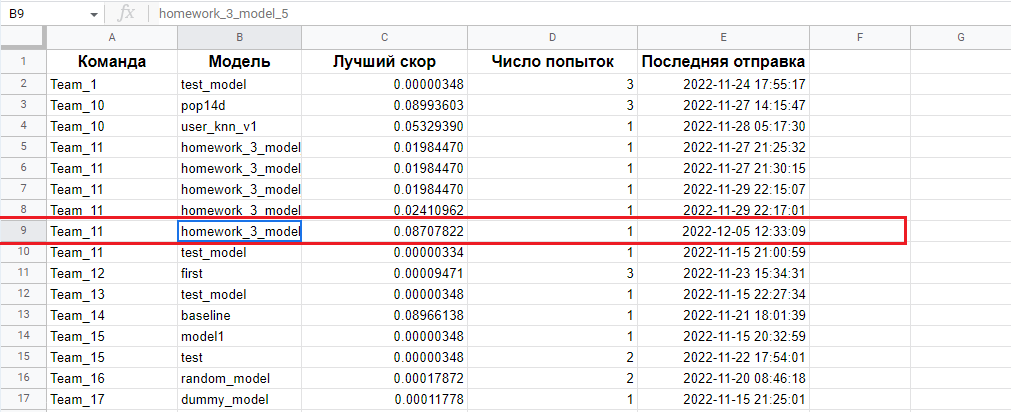